In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from google.colab import drive

# Configuration and constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 2
LEARNING_RATE = 0.001

# U-Net Model

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]) -> None:
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [3]:
# Generate dummy input and output data
x = torch.randn((3, 1, 161, 161))
model = UNet(in_channels=1, out_channels=1)
pred = model(x)
print(pred.shape)
print(x.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Dataset

In [4]:
# drive.mount("/content/drive/")
# !cp /content/drive/MyDrive/datasets/carvana_data.zip ./data.zip
# !unzip data.zip

In [5]:
TRAIN_PATH = os.path.join("data", "train")
TEST_PATH = os.path.join("data", "test")

In [6]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class SegmDataset(Dataset):
    """
    Custom dataset for segmentation tasks.

    Args:
        datapath (str): Path to the dataset directory.
        transform (callable, optional): A function/transform to apply to the image and mask.
    """
    def __init__(self, datapath, transform=None):
        self.datapath = datapath
        self.transform = transform
        self.image_dir = os.path.join(self.datapath, "images")
        self.mask_dir = os.path.join(self.datapath, "masks")
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name.replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(image_path).convert("RGB"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask==255.0] = 1.0

        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose(
    [
        A.Resize(height=INPUT_SIZE, width=INPUT_SIZE),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=INPUT_SIZE, width=INPUT_SIZE),
        ToTensorV2(),
    ]
)

In [8]:
train_dataset = SegmDataset(TRAIN_PATH, train_transforms)
val_dataset = SegmDataset(TEST_PATH, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check lengths
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 4576
Validation dataset size: 512


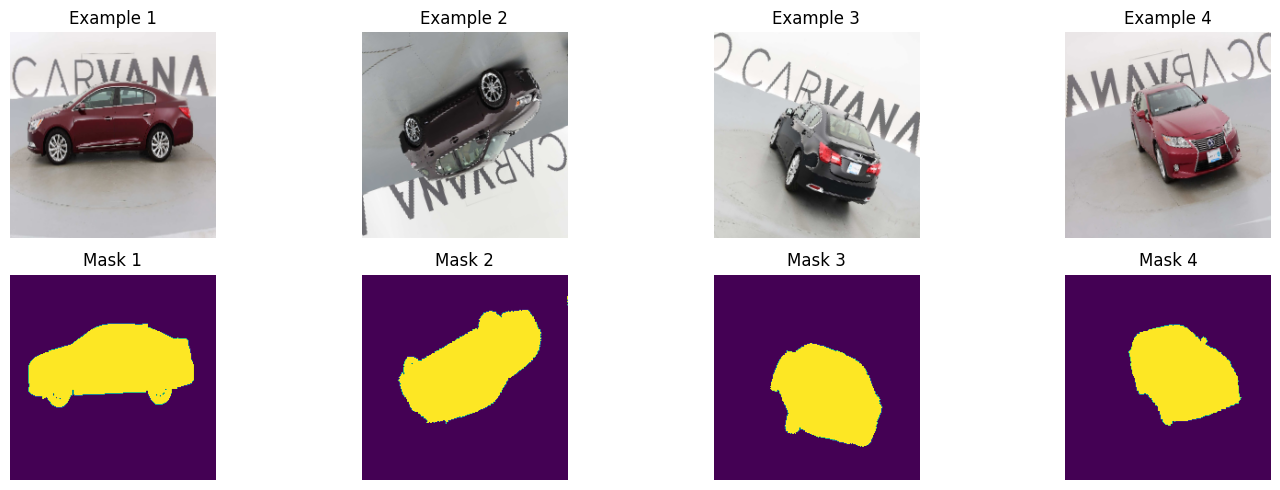

In [9]:
import matplotlib.pyplot as plt
import random

def visualize_examples(dataset, num_examples=4):
    """
    Visualizes random examples from the dataset along with their masks.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to visualize.
        num_examples (int, optional): Number of examples to display. Defaults to 4.
    """
    fig, axes = plt.subplots(2, num_examples, figsize=(15, 5))
    axes = axes.flatten()

    for i in range(num_examples):
        # Randomly select an example
        index = random.randint(0, len(dataset)-1)
        image, mask = dataset[index]

        image = image.permute(1, 2, 0)
        image = image.numpy().astype(np.uint8)
        mask = mask.numpy().astype(np.uint8)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Example {i+1}')

        # Display the mask
        axes[i+num_examples].imshow(mask)
        axes[i+num_examples].axis('off')
        axes[i+num_examples].set_title(f'Mask {i+1}')

    plt.tight_layout()
    plt.show()

visualize_examples(train_dataset)

# Train

In [10]:
def train(loader, model, optimizer, loss_fn, num_epochs):
    """
    Train the model.

    Args:
        loader (torch.utils.data.DataLoader): Data loader.
        model (torch.nn.Module): Model for training.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        loss_fn: Loss function.
        num_epochs (int): Number of training epochs.

    Returns:
        torch.nn.Module: Trained model.
    """
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, targets) in enumerate(loader):
            data = data.to(device=DEVICE)
            targets = targets.unsqueeze(1).to(device=DEVICE)

            # Forward
            predictions = model(data)
            loss = loss_fn(predictions, targets)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print loss
            if batch_idx % 10 == 9:
                print(f"Batch {batch_idx}/{len(loader)}: Loss {loss.item()}")
    return model

In [11]:
# Initialize the model
model = UNet(in_channels=3, out_channels=1)
model = model.to(device=DEVICE)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = train(train_loader, model, optimizer, criterion, NUM_EPOCHS)

torch.save(model.state_dict(), 'unet_carvana_segmentation.pth')

Epoch 1/2
Batch 9/143: Loss 0.3031926453113556
Batch 19/143: Loss 0.19775132834911346
Batch 29/143: Loss 0.17229576408863068
Batch 39/143: Loss 0.12924577295780182
Batch 49/143: Loss 0.1133204847574234
Batch 59/143: Loss 0.10052531212568283
Batch 69/143: Loss 0.08943616598844528
Batch 79/143: Loss 0.08281873166561127
Batch 89/143: Loss 0.08136308938264847
Batch 99/143: Loss 0.0690770298242569
Batch 109/143: Loss 0.06642157584428787
Batch 119/143: Loss 0.057825494557619095
Batch 129/143: Loss 0.04886839911341667
Batch 139/143: Loss 0.04718364030122757
Epoch 2/2
Batch 9/143: Loss 0.04627782851457596
Batch 19/143: Loss 0.04205317422747612
Batch 29/143: Loss 0.04403793439269066
Batch 39/143: Loss 0.037218887358903885
Batch 49/143: Loss 0.037239447236061096
Batch 59/143: Loss 0.041632458567619324
Batch 69/143: Loss 0.044092852622270584
Batch 79/143: Loss 0.030390987172722816
Batch 89/143: Loss 0.033461425453424454
Batch 99/143: Loss 0.034418076276779175
Batch 109/143: Loss 0.030337624251842

In [12]:
def check_accuracy(loader, model, device):
    """
    Check the accuracy of the model on the given data.

    Args:
        loader (torch.utils.data.DataLoader): Data loader.
        model (torch.nn.Module): Model for evaluation.
        device (torch.device): Device for computations.

    Returns:
        None
    """
    num_correct = 0
    num_pixels = 0
    model.eval()

    dice_score = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            preds = preds.squeeze(1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Accuracy: {100 * num_correct/num_pixels:.2f}% - Dice score: {100 * dice_score/len(loader):.2f}%")

In [13]:
check_accuracy(val_loader, model, DEVICE)

Accuracy: 99.17% - Dice score: 98.06%


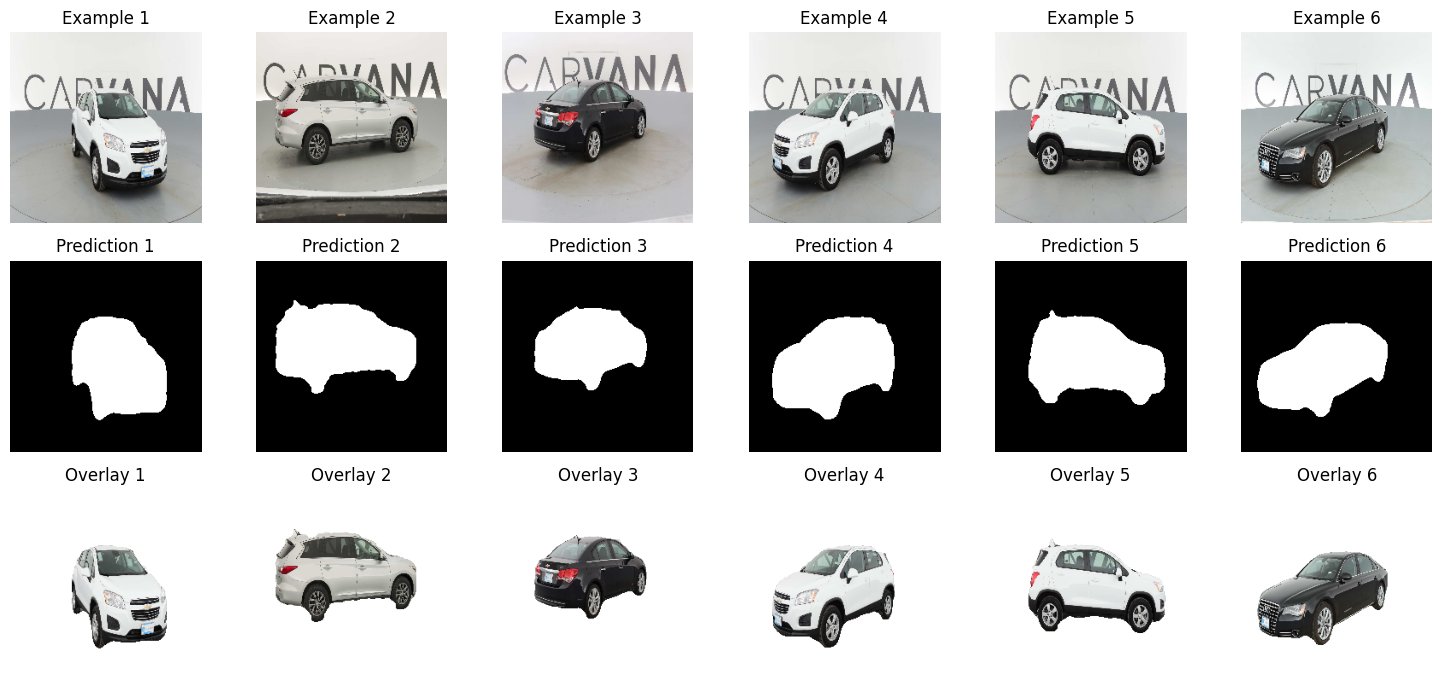

In [14]:
from PIL import Image

def visualize_predictions(dataset, num_examples=5):
    """
    Visualize random predictions from the dataset.

    Args:
        dataset (torch.utils.data.Dataset): Dataset containing images and masks.
        num_examples (int, optional): Number of examples to visualize.

    Returns:
        None
    """
    fig, axes = plt.subplots(3, num_examples, figsize=(15, 7))
    axes = axes.flatten()

    for i in range(num_examples):
        # Randomly select an example
        index = random.randint(0, len(dataset)-1)
        image, mask = dataset[index]

        image_tensor = image.unsqueeze(0).to(device=DEVICE)
        with torch.no_grad():
            predictions = torch.sigmoid(model(image_tensor))
            predictions = (predictions > 0.5).float()

        image = image.permute(1, 2, 0)
        image = image.numpy().astype(np.uint8)
        mask = mask.numpy().astype(np.uint8)

        predictions = predictions.squeeze(0).squeeze(0).cpu().numpy().astype(np.uint8)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Example {i+1}')

        # Display the mask
        axes[i+num_examples].imshow(predictions, cmap='gray')
        axes[i+num_examples].axis('off')
        axes[i+num_examples].set_title(f'Prediction {i+1}')

        # Overlay mask on image with transparency
        overlay = Image.fromarray(image)
        overlay_mask = Image.fromarray((predictions * 255).astype('uint8'), 'L')
        overlay.putalpha(overlay_mask)

        axes[i+2*num_examples].imshow(overlay)
        axes[i+2*num_examples].axis('off')
        axes[i+2*num_examples].set_title(f'Overlay {i+1}')

    plt.tight_layout()
    plt.show()

visualize_predictions(val_dataset, 6)